# Example Notebook: Using `fair-lnc-evaluation` on fairness benchmark datasets

This notebook demonstrates the usage of `fair-lnc-evaluation` to empirically evaluate several noise correction methods on the *Adult* dataset (https://www.openml.org/search?type=data&status=active&id=43898).

## Setup

First, import the necessary libraries.

The data should be loaded to a `Dataset` object. Some OpenML datasets can be loaded using the `get_data` method.

The considered label noise correction methods need to be derived classes from base class `LabelCorrectionModel`, from the `label-noise-correction` package (https://pypi.org/project/label-noise-correction/).

In [1]:
from fair_lnc_evaluation.empirical_evaluation import EmpiricalEvaluation
from fair_lnc_evaluation.classifier import Classifier
from fair_lnc_evaluation.data import get_data

from label_noise_correction.pl import PolishingLabels
from label_noise_correction.hlnc import HybridLabelNoiseCorrection
from label_noise_correction.cc import ClusterBasedCorrection
from sklearn.linear_model import LogisticRegression
import mlflow
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load data

dataset = get_data('adult', 'sex_Male')

# Initialize label noise correction methods

pl = PolishingLabels(LogisticRegression, n_folds=10)
hlnc = HybridLabelNoiseCorrection(n_clusters=20)
cc = ClusterBasedCorrection(n_iterations=10, n_clusters=20)

lnc = [pl, hlnc, cc]

## Running an experiment

To evaluate the considered label noise correction method on a dataset, initialize an `EmpiricalEvaluation` object and call its `start_experiment` method, which will run the necessary experiments according to the proposed methodology and save the results to MLflow.

Here, as we want to use a fairness benchmark dataset, which is originally biased, we set the `noise_injection` parameter to `False` so that the original labels are used.

In [4]:
for model in lnc:
    evaluation = EmpiricalEvaluation(dataset, model)

    evaluation.start_experiment(False, 
                                Classifier(LogisticRegression(), 'LogReg'),
                                metrics=['roc_auc', 'predictive_equality_difference'], 
                                classification_thresholds=[0.5])

2023/06/13 14:29:28 INFO mlflow.tracking.fluent: Experiment with name 'adult_sex_Male_PL' does not exist. Creating a new experiment.


Starting experiment: adult_sex_Male_PL


2023/06/13 14:29:58 INFO mlflow.tracking.fluent: Experiment with name 'adult_sex_Male_HLNC' does not exist. Creating a new experiment.


Starting experiment: adult_sex_Male_HLNC


2023/06/13 14:31:09 INFO mlflow.tracking.fluent: Experiment with name 'adult_sex_Male_CC' does not exist. Creating a new experiment.


Starting experiment: adult_sex_Male_CC


## Analyze Results

Next, we will retrieve the run data from MLflow.

In [5]:
results = {}

for model in lnc:
    results[model.name] = mlflow.search_runs(experiment_names=[f'adult_sex_Male_{model.name}'], order_by=['start_time DESC'])
    run = results[model.name]['tags.run'].unique()[0]
    results[model.name] = results[model.name].loc[results[model.name]['tags.run'] == run]

### Originally biased test set

Finally, let's analyze the experiment results by accessing the stored metrics and parameters. 

Here, we analyze how the **Polishing Labels** method performed on a noisy testing scenario (i.e., the *originally biased* test set), comparing its performance to the performance of using the *originally biased* train set (which has noisy labels).

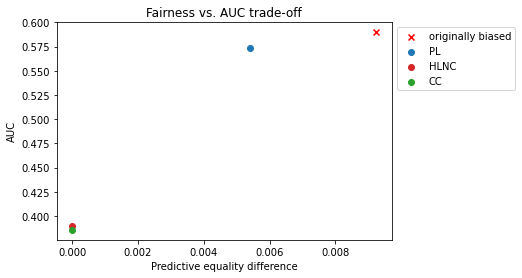

In [6]:
run = results['PL']
plt.scatter(run.loc[(run['tags.test_set'] == 'noisy') & (run['tags.train_set'] == 'noisy')]['metrics.predictive_equality_difference_0.5'].values[0],
            run.loc[(run['tags.test_set'] == 'noisy') & (run['tags.train_set'] == 'noisy')]['metrics.roc_auc'].values[0],
            color='red', marker='x', label='originally biased')

colors = {'PL': 'tab:blue', 'HLNC': 'tab:red', 'CC': 'tab:green'}

for model in lnc:
    run = results[model.name]
    plt.scatter(run.loc[(run['tags.test_set'] == 'noisy') & (run['tags.train_set'] == 'corrected')]['metrics.predictive_equality_difference_0.5'].values[0],
                run.loc[(run['tags.test_set'] == 'noisy') & (run['tags.train_set'] == 'corrected')]['metrics.roc_auc'].values[0],
                color=colors[model.name], label=model.name)

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel('Predictive equality difference')
plt.ylabel('AUC')
plt.title('Fairness vs. AUC trade-off')
plt.show()